### Finding Cut-off Temperatures for Controlling and decision making


This short script looks for the temperature at which the heat pump is to be turned off in every cycle, depending on the nominal power. Therefore we optimize one cycle for every nominal power between 3 and 4kW, with the condition, that the starting temperature must be equal to the ending temperature. Note that the higher powers don't manage to fulfill this constraint and ouput "None".

In [20]:

import gurobipy as gp
from gurobipy import GRB
import numpy as np
import matplotlib.pyplot as plt

Set parameter OutputFlag to value 1
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[x86] - Darwin 21.6.0 21H1320)

CPU model: Intel(R) Core(TM) i5-6267U CPU @ 2.90GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 6487 rows, 3605 columns and 12787 nonzeros
Model fingerprint: 0x0c03e5c7
Model has 3 quadratic objective terms
Variable types: 2163 continuous, 1442 integer (1442 binary)
Coefficient statistics:
  Matrix range     [1e-05, 3e+03]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-03, 9e+01]
Presolve removed 6255 rows and 3371 columns
Presolve time: 0.14s
Presolved: 232 rows, 234 columns, 727 nonzeros
Presolved model has 3 quadratic objective terms
Variable types: 89 continuous, 145 integer (145 binary)
Found heuristic solution: objective -0.0000000

Root relaxation: cutoff, 7 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current 

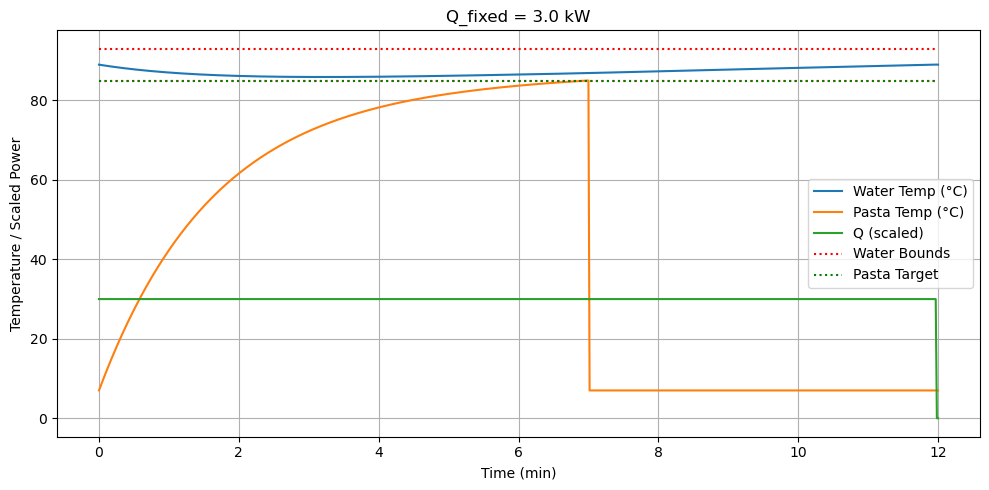

Set parameter OutputFlag to value 1
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[x86] - Darwin 21.6.0 21H1320)

CPU model: Intel(R) Core(TM) i5-6267U CPU @ 2.90GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 6487 rows, 3605 columns and 12787 nonzeros
Model fingerprint: 0x207af082
Model has 3 quadratic objective terms
Variable types: 2163 continuous, 1442 integer (1442 binary)
Coefficient statistics:
  Matrix range     [1e-05, 3e+03]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-03, 9e+01]
Presolve removed 6333 rows and 3449 columns
Presolve time: 0.13s
Presolved: 154 rows, 156 columns, 460 nonzeros
Presolved model has 3 quadratic objective terms
Variable types: 4 continuous, 152 integer (152 binary)
Found heuristic solution: objective 14.0532962
Found heuristic solution: objective 0.4521286

Root relaxation: objective 0.000000e+00, 312 iterati

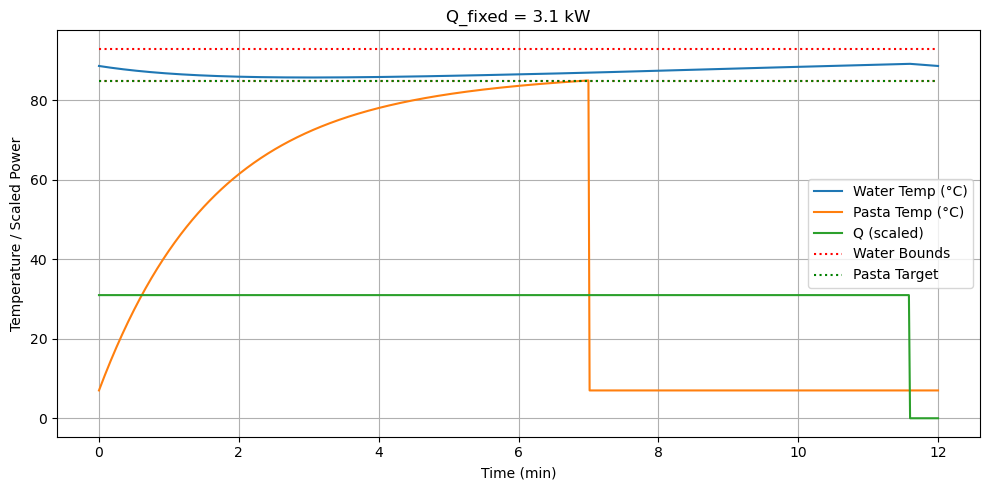

Set parameter OutputFlag to value 1
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[x86] - Darwin 21.6.0 21H1320)

CPU model: Intel(R) Core(TM) i5-6267U CPU @ 2.90GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 6487 rows, 3605 columns and 12787 nonzeros
Model fingerprint: 0x5c817fff
Model has 3 quadratic objective terms
Variable types: 2163 continuous, 1442 integer (1442 binary)
Coefficient statistics:
  Matrix range     [1e-05, 3e+03]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-03, 9e+01]
Presolve removed 6283 rows and 3399 columns
Presolve time: 0.24s
Presolved: 204 rows, 206 columns, 630 nonzeros
Presolved model has 3 quadratic objective terms
Variable types: 47 continuous, 159 integer (159 binary)
Found heuristic solution: objective 1.8666360

Root relaxation: objective -6.153185e-14, 440 iterations, 0.01 seconds (0.00 work units)

    Node

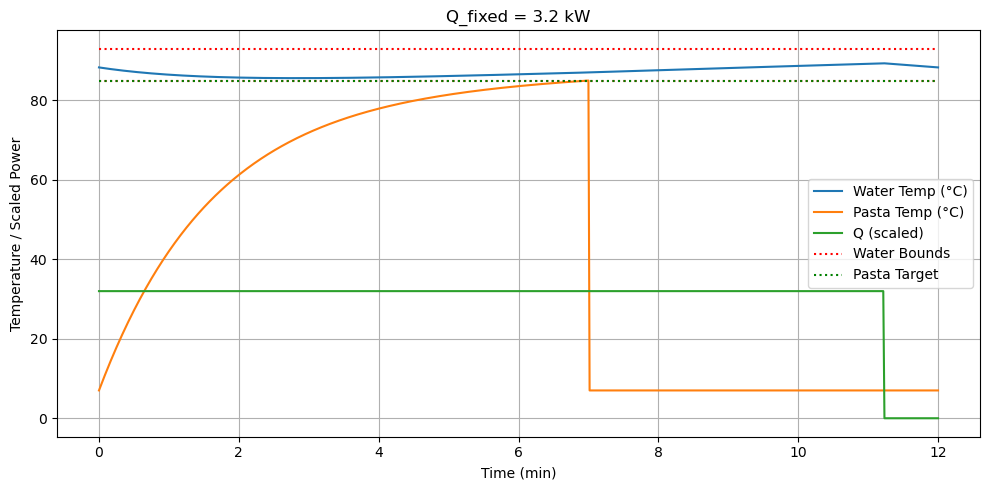

Set parameter OutputFlag to value 1
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[x86] - Darwin 21.6.0 21H1320)

CPU model: Intel(R) Core(TM) i5-6267U CPU @ 2.90GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 6487 rows, 3605 columns and 12787 nonzeros
Model fingerprint: 0x94c0b021
Model has 3 quadratic objective terms
Variable types: 2163 continuous, 1442 integer (1442 binary)
Coefficient statistics:
  Matrix range     [1e-05, 3e+03]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-03, 9e+01]
Presolve removed 6307 rows and 3423 columns
Presolve time: 0.14s
Presolved: 180 rows, 182 columns, 543 nonzeros
Presolved model has 3 quadratic objective terms
Variable types: 16 continuous, 166 integer (166 binary)
Found heuristic solution: objective 4.2439817

Root relaxation: objective 0.000000e+00, 374 iterations, 0.01 seconds (0.00 work units)

    Nodes

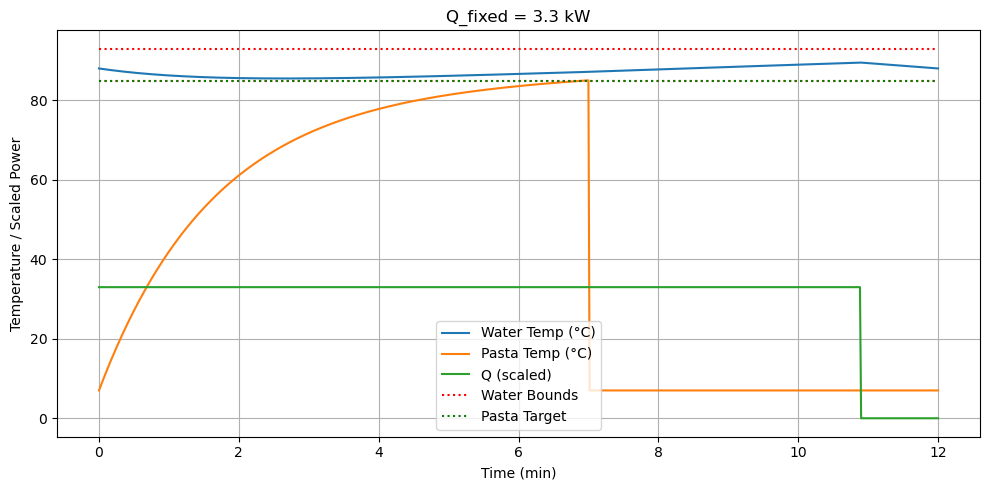

Set parameter OutputFlag to value 1
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[x86] - Darwin 21.6.0 21H1320)

CPU model: Intel(R) Core(TM) i5-6267U CPU @ 2.90GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 6487 rows, 3605 columns and 12787 nonzeros
Model fingerprint: 0x992e1035
Model has 3 quadratic objective terms
Variable types: 2163 continuous, 1442 integer (1442 binary)
Coefficient statistics:
  Matrix range     [1e-05, 3e+03]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-03, 9e+01]
Presolve removed 6276 rows and 3392 columns
Presolve time: 0.21s
Presolved: 211 rows, 213 columns, 649 nonzeros
Presolved model has 3 quadratic objective terms
Variable types: 41 continuous, 172 integer (172 binary)
Found heuristic solution: objective 7.5841658

Root relaxation: objective 0.000000e+00, 435 iterations, 0.01 seconds (0.00 work units)

    Nodes

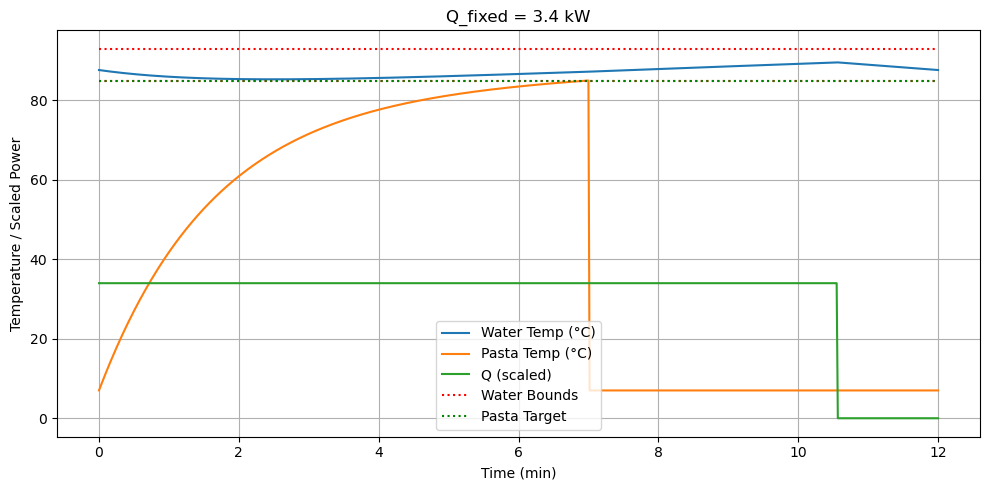

Set parameter OutputFlag to value 1
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[x86] - Darwin 21.6.0 21H1320)

CPU model: Intel(R) Core(TM) i5-6267U CPU @ 2.90GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 6487 rows, 3605 columns and 12787 nonzeros
Model fingerprint: 0x8e820b72
Model has 3 quadratic objective terms
Variable types: 2163 continuous, 1442 integer (1442 binary)
Coefficient statistics:
  Matrix range     [1e-05, 4e+03]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-03, 9e+01]
Presolve removed 6292 rows and 3408 columns
Presolve time: 0.30s
Presolved: 195 rows, 197 columns, 591 nonzeros
Presolved model has 3 quadratic objective terms
Variable types: 19 continuous, 178 integer (178 binary)
Found heuristic solution: objective 11.8871882

Root relaxation: objective 0.000000e+00, 406 iterations, 0.01 seconds (0.00 work units)

    Node

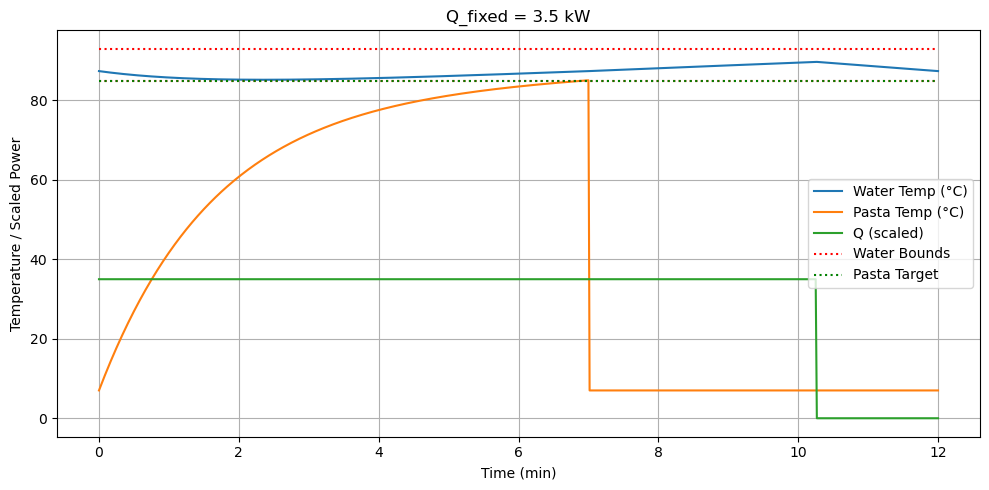

Set parameter OutputFlag to value 1
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[x86] - Darwin 21.6.0 21H1320)

CPU model: Intel(R) Core(TM) i5-6267U CPU @ 2.90GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 6487 rows, 3605 columns and 12787 nonzeros
Model fingerprint: 0x4435f864
Model has 3 quadratic objective terms
Variable types: 2163 continuous, 1442 integer (1442 binary)
Coefficient statistics:
  Matrix range     [1e-05, 4e+03]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-03, 9e+01]
Presolve removed 6303 rows and 3419 columns
Presolve time: 0.22s
Presolved: 184 rows, 186 columns, 551 nonzeros
Presolved model has 3 quadratic objective terms
Variable types: 3 continuous, 183 integer (183 binary)
Found heuristic solution: objective 4.2041028

Root relaxation: objective 0.000000e+00, 374 iterations, 0.00 seconds (0.00 work units)

    Nodes 

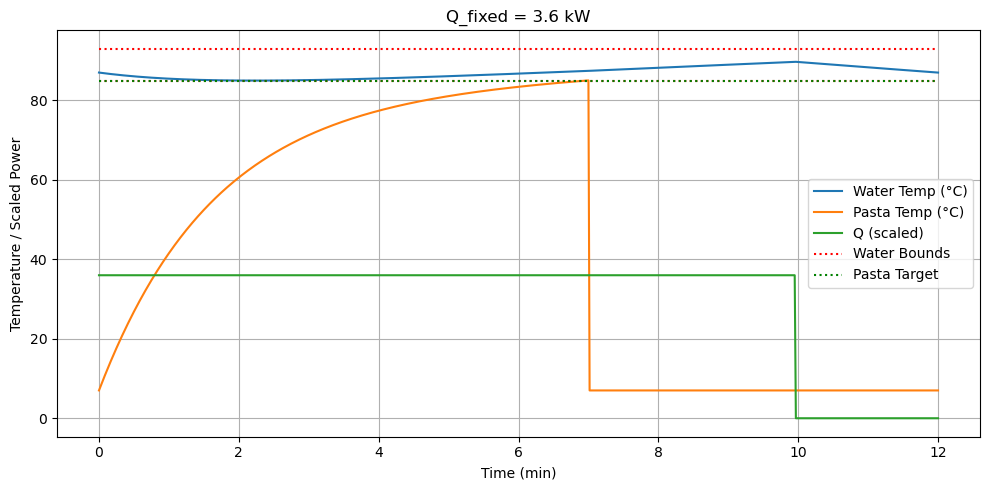

Set parameter OutputFlag to value 1
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[x86] - Darwin 21.6.0 21H1320)

CPU model: Intel(R) Core(TM) i5-6267U CPU @ 2.90GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 6487 rows, 3605 columns and 12787 nonzeros
Model fingerprint: 0xbd323767
Model has 3 quadratic objective terms
Variable types: 2163 continuous, 1442 integer (1442 binary)
Coefficient statistics:
  Matrix range     [1e-05, 4e+03]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-03, 9e+01]
Presolve removed 5007 rows and 2510 columns
Presolve time: 0.06s

Explored 0 nodes (0 simplex iterations) in 0.11 seconds (0.03 work units)
Thread count was 1 (of 4 available processors)

Solution count 0

Model is infeasible or unbounded
Best objective -, best bound -, gap -
Max water temperature for controlling 89.72465972649726
Set parameter OutputFlag to 

In [21]:
#list dictonary to store results
results = {}

powers = [3 + i/10 for i in range(10)]
for i in powers:
    Q_fixed_val = i*1000  # Watt

    # Time settings
    cook_s = 7 * 60
    cool_s = 5 * 60
    dt = 1
    n_cook = int(cook_s / dt)
    n_cool = int(cool_s / dt)
    n_total = n_cook + n_cool + 1

    T_env = 20
    T_pasta_0 = 7

    # System properties
    R_env = 30 / 1000
    R_pasta = 15 / 1000
    c_l = 4.18 * 1000
    c_pasta = 3.5 * 1000

    V_water = (47 - 0.4) * (27 - 0.4) * (20 - 0.2) / 1e6
    m_water = V_water * 1000
    m_pasta = 2

    C_water = m_water * c_l
    C_pasta = m_pasta * c_pasta

    t = np.linspace(0, cook_s + cool_s, n_total)

    # --- Gurobi Model ---
    model = gp.Model("FixedQ_TempDecision")
    model.setParam("OutputFlag", 1)

    # Variables
    z = model.addVars(n_total, vtype=GRB.BINARY, name="z")
    Q = model.addVars(n_total, lb=0, name="Q")
    delta_on = model.addVars(n_total, vtype=GRB.BINARY, name="delta_on")
    T_water = model.addVars(n_total, lb=0, name="T_water")
    T_pasta = model.addVars(n_total, lb=0, name="T_pasta")

    # Initial pasta temp
    model.addConstr(T_pasta[0] == T_pasta_0)

    # Heat pump on only once
    for t_ in range(1, n_total):
        model.addConstr(delta_on[t_] >= z[t_] - z[t_-1])
        model.addConstr(z[t_] <= z[t_-1])
        model.addConstr(delta_on[t_] >= 0)
        model.addConstr(delta_on[t_] <= 1)

    model.addConstr(gp.quicksum(delta_on[t_] for t_ in range(1, n_total)) <= 1)

    # Q is fixed value when on
    for i in range(n_total):
        model.addConstr(Q[i] == Q_fixed_val * z[i])

    # Dynamics
    for i in range(1, n_total):
        if i <= n_cook:
            model.addConstr(
                T_water[i] == T_water[i - 1] + dt * (
                    Q[i - 1] - (T_water[i - 1] - T_env) / R_env - (T_water[i - 1] - T_pasta[i - 1]) / R_pasta
                ) / C_water
            )
            model.addConstr(
                T_pasta[i] == T_pasta[i - 1] + dt * (
                    (T_water[i - 1] - T_pasta[i - 1]) / R_pasta
                ) / C_pasta
            )
        else:
            model.addConstr(
                T_water[i] == T_water[i - 1] + dt * (
                    Q[i - 1] - (T_water[i - 1] - T_env) / R_env
                ) / C_water
            )
            model.addConstr(T_pasta[i] == 7)

    # Temperature bounds
    for i in range(n_total):
        model.addConstr(T_water[i] >= 85)
        model.addConstr(T_water[i] <= 93)

    # Pasta ready
    model.addConstr(T_pasta[n_cook] >= 85)
    model.addConstr(T_pasta[n_cook] <= 85.1)

    # Optional: T_water[0] close to T_water[-1] (could also fix one)
    model.setObjective((T_water[n_total - 1] - T_water[0]) * (T_water[n_total - 1] - T_water[0]), GRB.MINIMIZE)

    model.optimize()

    # Extract results
    if model.status == GRB.OPTIMAL:
        Q_vals = np.array([Q[i].X for i in range(n_total)])
        T_water_vals = np.array([T_water[i].X for i in range(n_total)])
        T_pasta_vals = np.array([T_pasta[i].X for i in range(n_total)])

        print(f"Optimal T_water[0]: {T_water[0].X:.2f} °C")
        print(f"Optimal T_water[-1]: {T_water[n_total - 1].X:.2f} °C")

        # Plotting
        plt.figure(figsize=(10, 5))
        plt.plot(t / 60, T_water_vals, label="Water Temp (°C)")
        plt.plot(t / 60, T_pasta_vals, label="Pasta Temp (°C)")
        plt.plot(t / 60, Q_vals / 100, label="Q (scaled)")
        plt.hlines([85, 93], 0, t[-1] / 60, colors='r', linestyles='dotted', label="Water Bounds")
        plt.hlines([85], 0, t[-1] / 60, colors='g', linestyles='dotted', label="Pasta Target")
        plt.xlabel("Time (min)")
        plt.ylabel("Temperature / Scaled Power")
        plt.title(f"Q_fixed = {Q_fixed_val / 1000:.1f} kW")
        plt.grid()
        plt.legend()
        plt.tight_layout()
        plt.show()
        results[Q_fixed_val] = max(T_water_vals)   
    else:
        results[Q_fixed_val] = None
        print("Max water temperature for controlling", max(T_water_vals))


In [22]:
print("Results:", results)
#export results and store in csv file
import pandas as pd
results_df = pd.DataFrame(list(results.items()), columns=['Q_fixed_val', 'Max_T_water'])
results_df.to_csv('controlling_temperature_off_for_fixed_Q.csv', index=False)
print(results_df)

Results: {3000.0: 89.0295029164703, 3100.0: 89.21620654347247, 3200.0: 89.34496670846285, 3300.0: 89.52923882132066, 3400.0: 89.5754564121333, 3500.0: 89.70487954794248, 3600.0: 89.72465972649726, 3700.0: None, 3800.0: None, 3900.0: None}
   Q_fixed_val  Max_T_water
0       3000.0    89.029503
1       3100.0    89.216207
2       3200.0    89.344967
3       3300.0    89.529239
4       3400.0    89.575456
5       3500.0    89.704880
6       3600.0    89.724660
7       3700.0          NaN
8       3800.0          NaN
9       3900.0          NaN


In [26]:

print(list(results.keys()))

[3000.0, 3100.0, 3200.0, 3300.0, 3400.0, 3500.0, 3600.0, 3700.0, 3800.0, 3900.0]
